In [1]:
#!/bin/env python3

from argparse import ArgumentParser
from ast import Str

import numpy as np
import os
from os.path import join

from pathlib import Path

import pandas as pd
import pylab as plt
import random
import time
import warnings

from matplotlib.ticker import NullFormatter
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D


# wrapper for pylab, designed to do statistical plots using pandas dataframe 

from scipy.stats import beta, gaussian_kde


import sys
sys.path.append('/home/kblum/local/pism/sources/pism-emulator/')

from pismemulator.utils import param_keys_dict as keys_dict
from pismemulator.utils import kl_divergence
from pismemulator.kyle_utils import plot_random_groups, plot_posteriors, kl_divergences

import seaborn as sns



In [11]:
def plot_random_groups_big(df,vars,models,num_groups=10,per_group=50,seed=8675309):
    # df        : data frame of all models for true avg
    # vars      : list of variable (column) names
    # models    : list of available models (0,1,2 ...)
    # num_groups: number of ensembles
    # per_group : number of emulators per ensemble
    random.seed(seed)

    sns.set_theme(palette='colorblind')
    rows = int(np.ceil(len(vars)/2))
    cols = 2

    fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))

    groups = []
    m_true = sorted(random.sample(range(0,len(models),1),100))
    true = df[df['Model'].isin(m_true)]
    test = df[~df['Model'].isin(m_true)]
    m_test = sorted(test['Model'].unique())

    for i in range(num_groups):
        groups.append(random.sample(m_test,per_group))

    foo = 0
    bar = 0
    for i in range(rows):
        for j in range (cols):            
            var = vars[foo]
            # TODO define histogram of avg
            sns.kdeplot(data=true, x=var,ax=axes[i,j],color='black')
            print(foo,var)
            foo += 1
            for group in groups:
                temp = df[df['Model'].isin(group)]
                sns.kdeplot(data=temp,x=var,ax=axes[i,j],color='green',alpha = .5) # remove y axis values, add x axis label
                axes[i,j].set(xlabel=keys_dict[var],yticklabels=[],ylabel=None)

def kl_div_spec_true(df,true,vars,models,num_groups=10,per_group=50,seed=8675309):
    # this was designed to calculate the kl divergences of random sub-ensembles from a larger "true" ensemble
    # df : data frame of all models for true avg
    # vars: list of variable (column) names
    # models: list of available models (0,1,2 ...)
    # num_groups: number of ensembles
    # per_group: number of emulators per ensemble

    divs = {}
    groups = []

    random.seed(seed)
    for i in range(num_groups):
        groups.append(random.sample(sorted(models),per_group))
        
    bar = 0
    for i in range(len(vars)):
        kl_sum = 0
        var = vars[i]
        p = np.histogram(true[var], bins=60,density=True)[0]      # the true posterior
        for group in groups:
            temp = df[df['Model'].isin(group)]
            q = np.histogram(temp[var],bins=60,density=True)[0] # the sub-ensemble posterior
            kl_sum += np.abs(kl_divergence(p,q))
        kl_average  = kl_sum / num_groups
        divs[var] = kl_average
    return divs

In [3]:
# Work in progess, this notebook is meant to plot several different randomly selected ensembles, subsets of the 200 that are avaiable

In [4]:
emulator_dirs = ['/data/work/antarctica_calibration/speedemulator/emulator_dirs/pp_200m_1275t_1000e']
samples_files = {}

rc_samples_file = "/data/work/antarctica_calibration/speed_calibration_regularized_coulomb_128.csv"
pp_samples_file = "/data/work/antarctica_calibration/speed_calibration_pseudo_plastic_128.csv"

for emulator_dir in emulator_dirs:
    # This is janky, should find a better way to do this
    if 'rc_' in emulator_dir:
        samples_files[emulator_dir] = rc_samples_file
        print('rc')
    else:
        samples_files[emulator_dir] = pp_samples_file
        print('pp')

frac         = 0.1

print("Loading prior samples\n")
rc_samples = pd.read_csv(rc_samples_file).drop(columns=["id"])
pp_samples = pd.read_csv(pp_samples_file).drop(columns=["id"])

X_keys = rc_samples.keys()

l_post = []


pp
Loading prior samples



In [5]:
posterior_dfs = []
df_models     = []
titles        = []
for emulator_dir in emulator_dirs:
    X_list = []
    p = Path(f"{emulator_dir}/posterior_samples/")
    print("Loading posterior samples\n")
    for m, m_file in enumerate(sorted(p.glob("X_posterior_model_*.csv.gz"))):
        #print(f"  -- {m_file}")
        df = pd.read_csv(m_file).sample(frac=frac)
        if "Unnamed: 0" in df.columns:
            df.drop(columns=["Unnamed: 0"], inplace=True)
        model = m_file.name.split("_")[-1].split(".")[0]
        df["Model"] = int(model)
        X_list.append(df)

    print(f"Merging posteriors into dataframe")
    posterior_df = pd.concat(X_list)
    posterior_dfs.append(posterior_df)
    #X_posterior = posterior_df.drop(columns=["Model"]).values
    models = posterior_df['Model'].unique()
    df_models.append(models)
    titles.append(emulator_dir)



Loading posterior samples

Merging posteriors into dataframe


In [20]:
groups = []
random.seed()
m_true = random.sample(sorted(models),100)
true = posterior_df[posterior_df['Model'].isin(m_true)]
test = posterior_df[~posterior_df['Model'].isin(m_true)]
m_test = sorted(test['Model'].unique())

In [21]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
xs = np.linspace(5,100,20)
for per_group in xs:
    print(per_group)
    lcurves[per_group] = kl_div_spec_true(df=test, true=true, vars=X_keys, models=m_test, per_group=int(per_group), num_groups=100,seed=None)


5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0


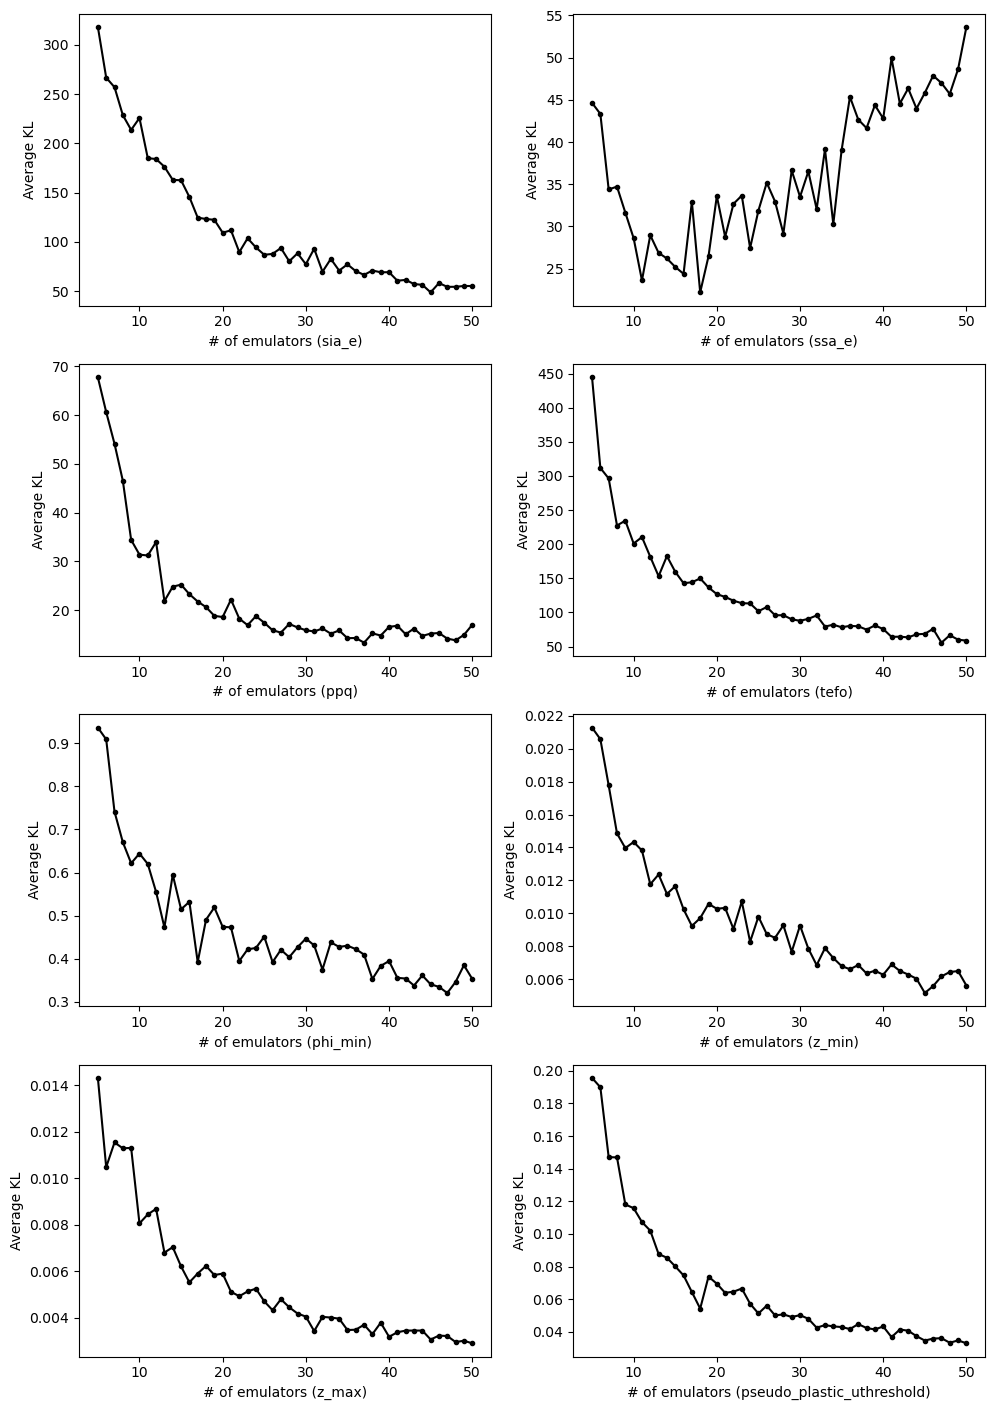

In [19]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        foo += 1
        ys = []
        for bar in xs:
            ys.append(lcurves[bar][var])
        
        axes[i,j].plot(xs,ys,'k.-')
        axes[i,j].set(xlabel=f'# of emulators ({var})',ylabel="Average KL")


In [13]:
#plot_random_groups_big(posterior_df, X_keys, models, per_group=75,seed=123)

sia_e
ssa_e
ppq
tefo
phi_min
z_min
z_max
pseudo_plastic_uthreshold


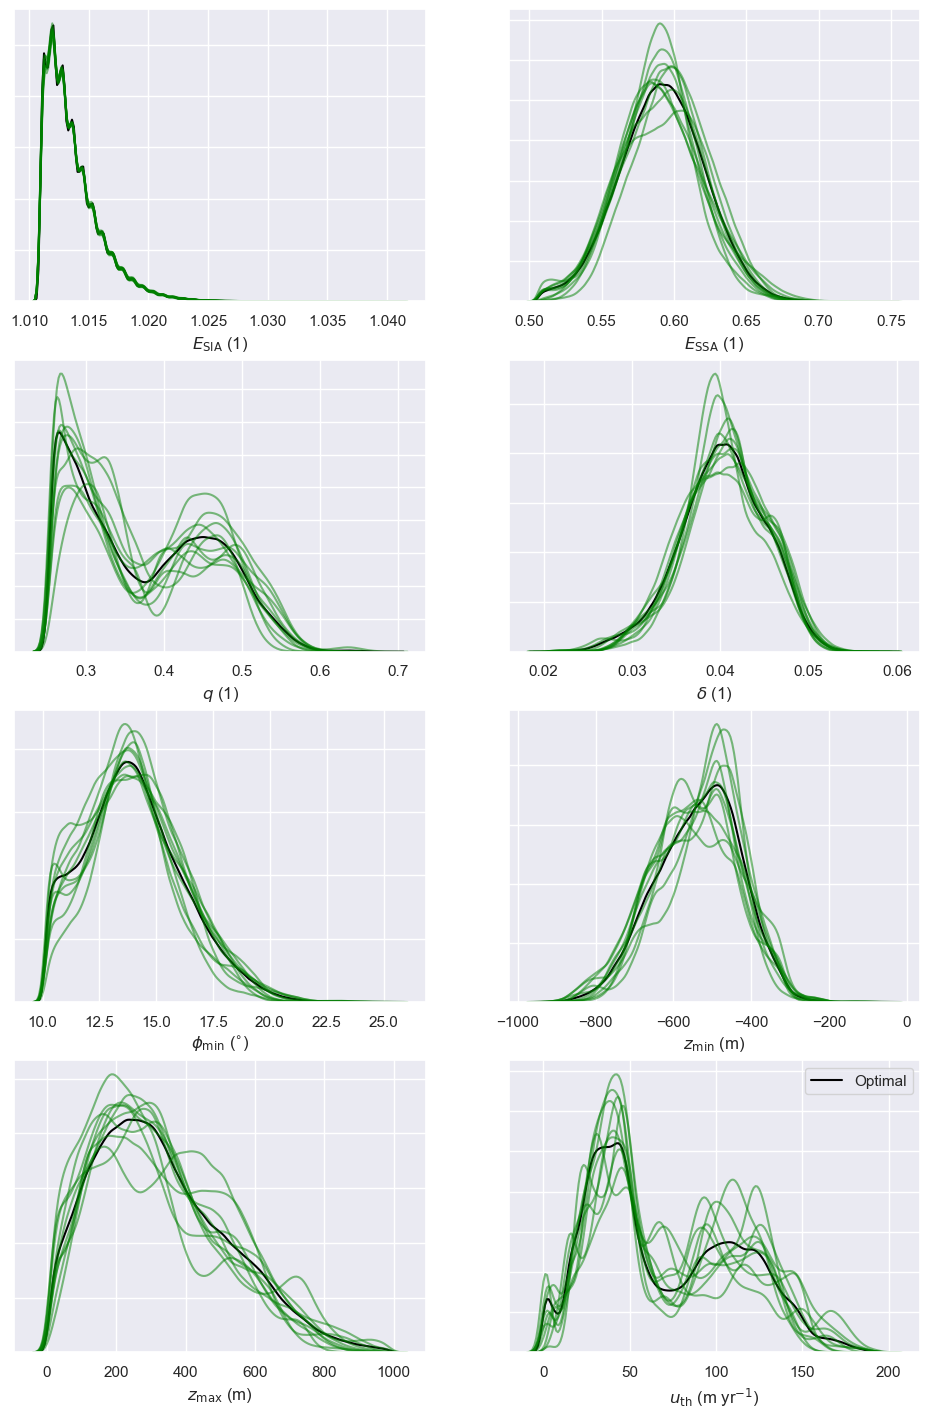

In [14]:
plot_random_groups(posterior_df,X_keys,models=range(0,200),num_groups=10,per_group=50,seed=123)

In [9]:
np.seterr(invalid='ignore',divide='ignore')
lcurves = {}
xs = np.linspace(5,200,40)
for per_group in xs:
    print(per_group)
    lcurves[per_group] = kl_divergences(posterior_df, X_keys, models, per_group=int(per_group),num_groups=20,seed=542356267)

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
200.0


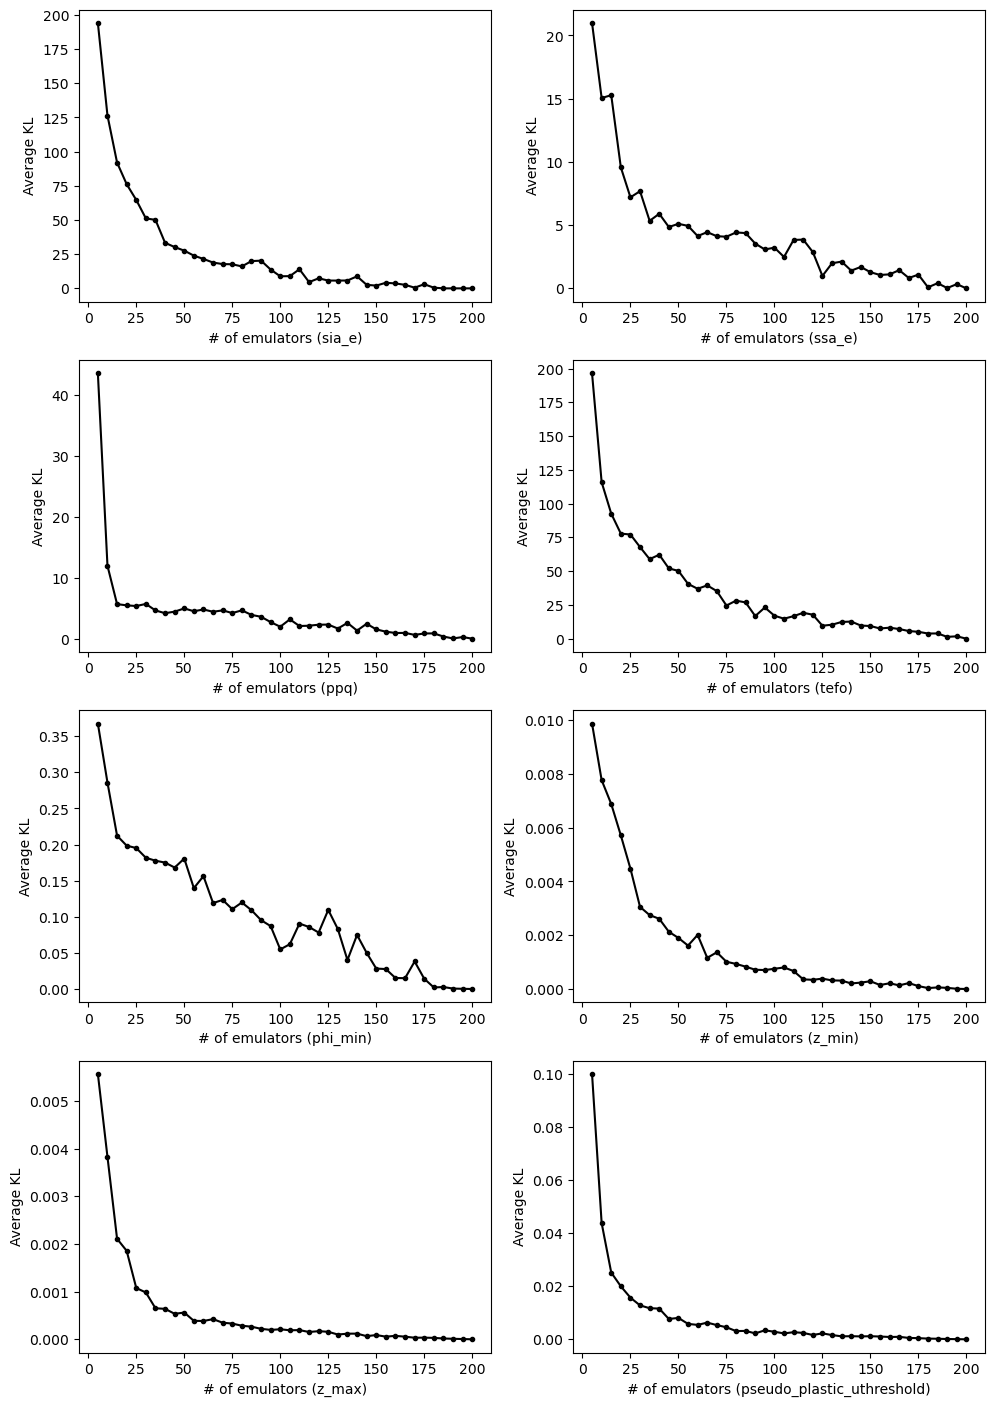

In [10]:
rows = int(np.ceil(len(X_keys)/2))
cols = 2

fig, axes = plt.subplots(rows,cols,figsize=(11.69,17.44))
foo = 0

for i in range(rows):
    for j in range (cols):
        var = X_keys[foo]
        foo += 1
        ys = []
        for bar in xs:
            ys.append(lcurves[bar][var])
        
        axes[i,j].plot(xs,ys,'k.-')
        axes[i,j].set(xlabel=f'# of emulators ({var})',ylabel="Average KL")


In [23]:
for pergroup in [15,50,100]:
    print(kl_divergences(posterior_df, X_keys, models, per_group=int(pergroup),num_groups=20)['ppq'])

6.148940228961676
3.8164244835880643
2.4483573942413543
